##  <span style='background :#96e773' > 1. Introduction </span>

Ce notebook est dédié à la sélection de l'algorithme de machine learning, à l'optimisation de ses hyperparamètres et à son interprétabilité avec la librairie SHAP.


In [101]:
# Importation des librairies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sys
# import statsmodels.api as sm
import sklearn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Versions
print('Version des librairies utilisées:')
print('Python ' + sys.version)
print('Pandas ' + pd.__version__)
print('NumPy ' + np.__version__)
print('Seaborn ' + sns.__version__)
print('Matplotlib ' + matplotlib.__version__)
print('Sklearn ' + sklearn.__version__)

Version des librairies utilisées:
Python 3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]
Pandas 1.5.2
NumPy 1.23.5
Seaborn 0.12.2
Matplotlib 3.5.3
Sklearn 1.2.2


In [102]:
from matplotlib import rcParams

# Définition des tailles de polices des figures


SMALL_SIZE = 15
MEDIUM_SIZE = 16
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)

rcParams['axes.titlepad'] = 20
plt.rcParams['figure.dpi'] = 100

sns.set(style="darkgrid")

**Fonctions**

In [103]:
def dim(df):
    x, y = df.shape
    print(f'Le jeu de données contient {x} lignes et {y} colonnes.')

In [104]:
def print_confusion_matrix(model, X, y_true):
    # Make predictions using the input data
    y_pred = model.predict(X)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a heatmap plot of the confusion matrix using Seaborn
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

    # Set plot labels
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

In [105]:
def plot_results(results_df, figsize):

    sns.set_style("darkgrid")

    fig, (ax_1, ax_2, ax_3, ax_4, ax_5) = plt.subplots(5, 1, figsize=figsize)

    sns.barplot(y=results_df["model"], x=results_df["f2_score_mean"], ax=ax_1, palette="GnBu_d")
    ax_1.set(xlabel='f2 score')
    ax_1.set(ylabel='')
    ax_1.bar_label(ax_1.containers[0], fmt="%.4f", size=12)

    sns.barplot(y=results_df["model"], x=results_df["roc_auc_mean"], ax=ax_2, palette="GnBu_d")
    ax_2.set(xlabel='ROC AUC')
    ax_2.set(ylabel='')
    ax_2.bar_label(ax_2.containers[0], fmt="%.4f", size=12)

    sns.barplot(y=results_df["model"], x=results_df["pr_auc_mean"], ax=ax_3, palette="GnBu_d")
    ax_3.set(xlabel='precision recall AUC')
    ax_3.set(ylabel='')
    ax_3.bar_label(ax_3.containers[0], fmt="%.4f", size=12)

    sns.barplot(y=results_df["model"], x=results_df["custom_score_mean"], ax=ax_4, palette="GnBu_d")
    ax_4.set(xlabel='custom score')
    ax_4.set(ylabel='')
    ax_4.bar_label(ax_4.containers[0], fmt="%.4f", size=12)

    sns.barplot(y=results_df["model"], x=results_df["time_mean"], ax=ax_5, palette="GnBu_d")
    ax_5.set(xlabel='mean time (s)')
    ax_5.set(ylabel='')
    ax_5.bar_label(ax_5.containers[0], fmt="%.4f", size=12)

    plt.tight_layout()
    plt.show()

<br>

---

##  <span style='background :#96e773' > 2. Chargement des jeux de données </span>

In [106]:
X_train_xgb_med = pd.read_csv('X_train_xgb_med.csv')
X_validation_xgb_med = pd.read_csv('X_validation_xgb_med.csv')
test_xgb_med = pd.read_csv('test_xgb_med.csv')

On importe les différentes listes de features établies dans le notebook précédent.

In [107]:
import joblib

selected_features = joblib.load('selected_features.joblib')
liste_totale_accepted = joblib.load('liste_totale_accepted.joblib')
selected_features_60 = joblib.load('selected_features_60.joblib')

On crée trois jeux de données :
- un avec 609 features (suffixe "lgbm")
- un avec 294 features (suffixe "cumul")
- un avec 151 features (suffixe "mini")

In [108]:
X_train_fs_lgbm = X_train_xgb_med[selected_features]
X_valid_fs_lgbm = X_validation_xgb_med[selected_features]
test_fs_lgbm = test_xgb_med[['SK_ID_CURR'] + selected_features]

X_train_fs_cumul = X_train_xgb_med[liste_totale_accepted]
X_valid_fs_cumul = X_validation_xgb_med[liste_totale_accepted]
test_fs_cumul = test_xgb_med[['SK_ID_CURR'] + liste_totale_accepted]

X_train_fs_mini = X_train_xgb_med[selected_features_60]
X_valid_fs_mini = X_validation_xgb_med[selected_features_60]
test_fs_mini = test_xgb_med[['SK_ID_CURR'] + selected_features_60]

In [109]:
y_train = pd.read_csv('y_train.csv')
y_train = y_train.squeeze()

y_validation = pd.read_csv('y_validation.csv')
y_validation = y_validation.squeeze()

In [110]:
print(X_train_fs_lgbm.shape)
print(X_valid_fs_lgbm.shape)
print(test_fs_lgbm.shape)

print(X_train_fs_cumul.shape)
print(X_valid_fs_cumul.shape)
print(test_fs_cumul.shape)

print(X_train_fs_mini.shape)
print(X_valid_fs_mini.shape)
print(test_fs_mini.shape)

print(y_train.shape)
print(y_validation.shape)

(246003, 609)
(61501, 609)
(48744, 610)
(246003, 294)
(61501, 294)
(48744, 295)
(246003, 151)
(61501, 151)
(48744, 152)
(246003,)
(61501,)


<br>

---

##  <span style='background :#96e773' > 3. Model selection </span>
### <span style='background :#e3e33d' > 3.1 Définition des métriques </span>

Nous utiliserons les métriques suivantes pour comparer les différents modèles :

- précision
- rappel
- score f1
- score f2
- AUC ROC
- AUC Precision-Recall

Nous allons également utiliser un score personnalisé, qui mettra l'accent sur le fait qu'un mauvais client prédit bon client (faux négatif) coûte dix fois plus qu'un bon client prédit mauvais (faux positif).

On associe les poids p suivants aux quatre valeurs possibles de la matrice de confusion (vrai négatif TN, vrai positif TP, faux positif FP, faux négatif FN) :

- p_TN = 1 pour TN
- p_TP = 1 pour TP
- p_FP = -1 pour FP
- p_FN = -10 pour FN

On définit la formule suivante pour calculer le score personnalisé :

score = p_TN * TN + p_TP * TP - p_FP * FP - p_FN * FN

Ce score est ensuite normalisé entre 0 et 1.

In [111]:
from sklearn.metrics import make_scorer, confusion_matrix

def custom_score(y_true, y_pred):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Extract the components of the confusion matrix
    TN, FP, FN, TP = cm.ravel()

    # Calculate the custom score with different weights
    score = 1 * TN + 1 * TP - 1 * FP - 10 * FN

    # Calculate the best possible score
    best_score = 1 * (TN + FP) + 1 * (TP + FN)

    # Calculate the worst possible score
    worst_score = -1 * (TN + FP) - 10 * (TP + FN)

    # Normalize the score between 0 and 1
    normalized_score = (score - worst_score) / (best_score - worst_score)

    return normalized_score


# Create a scorer object for use with scikit-learn functions
custom_scorer = make_scorer(custom_score)

Les scores f1, f2 et le score personnalisé dépendent du seuil de classification. Pour cette raison, nous utiliserons la fonction suivante qui permet de calculer le meilleur score possible en faisant varier ce seuil.

In [112]:
# Fonction qui calcule le meilleur score possible en fonction du seuil de classification

def find_optimal_threshold(y_true, y_pred_probs, thresholds, score_func):
    best_threshold = thresholds[0]
    best_score = 0

    for threshold in thresholds:
        y_pred = (y_pred_probs >= threshold).astype(int)

        if score_func == precision_score:

            score = precision_score(y_true, y_pred, zero_division=1.0)

        elif score_func ==  fbeta_score:

             score = fbeta_score(y_true, y_pred, beta=2)

        else:
            score = score_func(y_true, y_pred)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return  best_score, best_threshold

<br>

---

### <span style='background :#e3e33d' > 3.2 Comparaison des modèles </span>

Nous allons tester les modèles suivants :

- un modèle naif "Baseline_Random" qui classe les clients de façon aléatoire
- un modèle naif "Baseline_All_Pay_Back" qui classe tous les clients comme bon client
- un modèle naif "Baseline_None_Pay_Back" qui classe les clients comme mauvais client
- un modèle de régression logistique
- un modèle KNN
- 5 modèles ensemblistes : Random_Forest, Extra_Trees, LightGBM, XGBoost et CatBoost.

Dans un premier temps, on n'utilise aucune technique de resampling mais seulement les méthodes de pondération des classes inhérentes à chaque modèle (méthode indisponible pour KNN).
Ces méthodes attribuent des poids différents aux classes lors de l’apprentissage du modèle, de manière à accorder plus d’importance aux instances de la classe minoritaire et à atténuer l’effet du déséquilibre des classes.

On effectue une validation croisée stratifiée à 3 splits et on enregistre les résultats avec MLFlow. Les 3 jeux de données sont testés.

In [113]:
import mlflow
import mlflow.sklearn
import logging
logging.getLogger('mlflow').setLevel(logging.ERROR)

mlflow.set_tracking_uri('file:///E:\OneDrive\Data S\Openclassroom\Formation\Projets\P7\mlruns')

In [114]:
def create_model_without_class_weights(model_name):
    if model_name == 'Logistic_Regression':
        return make_pipeline(StandardScaler(), LogisticRegression(random_state=42, n_jobs=-1))
    elif model_name == 'Random_Forest':
        return RandomForestClassifier(random_state=42, n_jobs=-1)
    elif model_name == 'Extra_Trees':
        return ExtraTreesClassifier(random_state=42, n_jobs=-1)
    elif model_name == 'LightGBM':
        return lgb.LGBMClassifier(objective='binary', random_state=42, n_jobs=-1)
    elif model_name == 'XGBoost':
        return XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)
    elif model_name == 'CatBoost':
        return CatBoostClassifier(random_state=42, silent=True)
    else:
        return models[model_name]

In [115]:
import time
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold

def evaluate_models_cross(models, X, y, resampling_methods, n_splits=3):
    results = []

    stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, model in models.items():

        for method_name, method in resampling_methods.items():
            with mlflow.start_run(run_name=name + '_' + method_name):

                # Create a new model instance without class weights if a resampling method is used
                if method is not None:
                    model_no_weights = create_model_without_class_weights(name)
                    model_to_use = model_no_weights
                else:
                    model_to_use = model

                scores = {
                    'precision': [],
                    'recall': [],
                    'f1_score': [],
                    'f2_score': [],
                    'roc_auc': [],
                    'pr_auc': [],
                    'custom_score': [],
                    'time': []
                }

                for train_index, valid_index in stratified_kfold.split(X, y):
                    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
                    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

                    if method is not None:
                        # Apply resampling technique to the training set
                        X_resampled, y_resampled = method.fit_resample(X_train, y_train)
                    else:
                        X_resampled, y_resampled = X_train, y_train

                    # Record the start time
                    start_time = time.time()

                    model_to_use.fit(X_resampled, y_resampled)

                    # Make predictions on the validation set
                    y_pred_proba = model_to_use.predict_proba(X_valid)[:, 1]
                    y_pred = model_to_use.predict(X_valid)

                    # Find the optimal threshold
                    thresholds = np.arange(0, 1, 0.05)

                    precision = precision_score(y_valid, y_pred, zero_division=1.0)
                    recall = recall_score(y_valid, y_pred)
                    f1, _ = find_optimal_threshold(y_valid, y_pred_proba, thresholds, score_func=f1_score)
                    f2, _ = find_optimal_threshold(y_valid, y_pred_proba, thresholds, score_func=fbeta_score)
                    custom, _ = find_optimal_threshold(y_valid, y_pred_proba, thresholds, score_func=custom_score)
                    roc_auc = roc_auc_score(y_valid, y_pred_proba)
                    avg_precision = average_precision_score(y_valid, y_pred_proba)

                    # Record the end time and compute the elapsed time
                    end_time = time.time()
                    elapsed_time = end_time - start_time

                    scores['precision'].append(precision)
                    scores['recall'].append(recall)
                    scores['f1_score'].append(f1)
                    scores['f2_score'].append(f2)
                    scores['roc_auc'].append(roc_auc)
                    scores['pr_auc'].append(avg_precision)
                    scores['custom_score'].append(custom)
                    scores['time'].append(elapsed_time)

                results.append({
                    'model': name,
                    'resampling': method_name,
                    'precision_mean': np.mean(scores['precision']),
                    'recall_mean': np.mean(scores['recall']),
                    'f1_score_mean': np.mean(scores['f1_score']),
                    'f1_score_std': np.std(scores['f1_score']),
                    'f2_score_mean': np.mean(scores['f2_score']),
                    'roc_auc_mean': np.mean(scores['roc_auc']),
                    'roc_auc_std': np.std(scores['roc_auc']),
                    'pr_auc_mean': np.mean(scores['pr_auc']),
                    'pr_auc_std': np.std(scores['pr_auc']),
                    'custom_score_mean': np.mean(scores['custom_score']),
                    'time_mean': np.mean(scores['time'])
                })

                print(f'modèle {model} ended')

                # Log metrics to MLFlow
                mlflow.log_metric('precision_mean', float(np.mean(scores['precision'])))
                mlflow.log_metric('recall_mean', float(np.mean(scores['recall'])))
                mlflow.log_metric('f1_score_mean', float(np.mean(scores['f1_score'])))
                mlflow.log_metric('f1_score_std', float(np.std(scores['f1_score'])))
                mlflow.log_metric('f2_score_mean', float(np.mean(scores['f2_score'])))
                mlflow.log_metric('roc_auc_mean', float(np.mean(scores['roc_auc'])))
                mlflow.log_metric('roc_auc_std', float(np.std(scores['roc_auc'])))
                mlflow.log_metric('pr_auc_mean', float(np.mean(scores['pr_auc'])))
                mlflow.log_metric('pr_auc_std', float(np.std(scores['pr_auc'])))
                mlflow.log_metric('custom_score_mean', float(np.mean(scores['custom_score'])))
                mlflow.log_metric('time_mean', float(np.mean(scores['time'])))

                # Save the model to MLFlow
                mlflow.sklearn.log_model(model_to_use, "model")

                # End the run
                mlflow.end_run()

    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(results)

    return results_df

In [116]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()

models = {
    'Baseline_Random': DummyClassifier(strategy='uniform', random_state=42),
    'Baseline_All_Pay_Back': DummyClassifier(strategy='constant', constant=0),
    'Baseline_None_Pay_Back': DummyClassifier(strategy='constant', constant=1),
    'Logistic_Regression': make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1)),
    'K-Nearest_Neighbors': make_pipeline(StandardScaler(), KNeighborsClassifier(n_jobs=-1)),
    'Random_Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'Extra_Trees': ExtraTreesClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(objective='binary', scale_pos_weight=scale_pos_weight_value, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight_value, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(auto_class_weights='Balanced', random_state=42, silent=True)
}

# Define the resampling methods
resampling_methods = {'No_Resampling': None}

In [117]:
mlflow.set_experiment('cross_validation_experiment_full_features')

results_df = evaluate_models_cross(models, X_train_fs_lgbm, y_train, resampling_methods, n_splits=3)
results_df = results_df.sort_values(by='pr_auc_mean', ascending=False)

results_df.to_csv('model_selection_df_1.csv', index=False)

In [118]:
results_df = pd.read_csv('model_selection_df_1.csv')
results_df

,model,resampling,precision_mean,recall_mean,f1_score_mean,f1_score_std,f2_score_mean,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,custom_score_mean,time_mean
0,LightGBM,No_Resampling,0.189014,0.695337,0.335924,0.004308,0.452756,0.789419,0.001873,0.274766,0.002946,0.748414,13.452551
1,CatBoost,No_Resampling,0.217875,0.590392,0.333099,0.003644,0.448522,0.784914,0.001310,0.274593,0.003649,0.747224,79.451223
2,Logistic_Regression,No_Resampling,0.185495,0.696848,0.332618,0.003060,0.449405,0.785241,0.000893,0.267497,0.003172,0.746868,13.381285
3,XGBoost,No_Resampling,0.203564,0.579615,0.316873,0.002926,0.434678,0.768639,0.002023,0.251860,0.002074,0.738383,60.856914
4,Extra_Trees,No_Resampling,0.568570,0.004129,0.301615,0.001105,0.416449,0.751101,0.000858,0.227163,0.002845,0.730488,26.271556
5,Random_Forest,No_Resampling,0.431521,0.008410,0.295475,0.003713,0.419018,0.753576,0.003201,0.217128,0.003142,0.727362,32.788017
6,K-Nearest_Neighbors,No_Resampling,0.248769,0.029963,0.197781,0.000877,0.305099,0.598509,0.001692,0.112706,0.000755,0.684203,104.046536
7,Baseline_Random,No_Resampling,0.080548,0.499547,0.149386,0.000010,0.305099,0.500000,0.000000,0.080723,0.000006,0.674327,1.749149
8,Baseline_All_Pay_Back,No_Resampling,1.000000,0.000000,0.149386,0.000010,0.305099,0.500000,0.000000,0.080723,0.000006,0.674327,1.710239
9,Baseline_None_Pay_Back,No_Resampling,0.080723,1.000000,0.149386,0.000010,0.305099,0.500000,0.000000,0.080723,0.000006,0.325673,1.734824


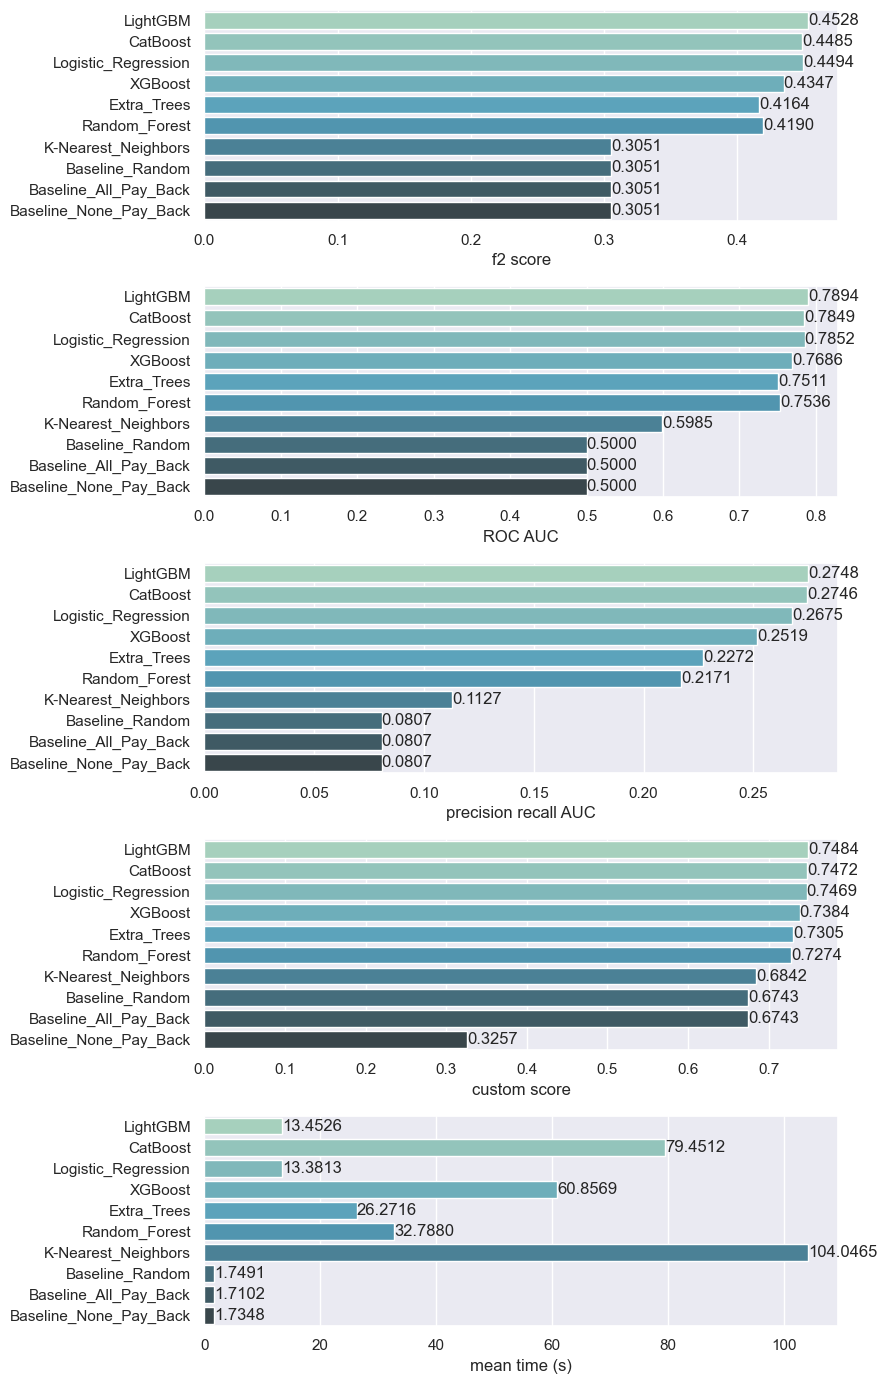

In [119]:
plot_results(results_df, (9, 14))

In [120]:
mlflow.set_experiment('cross_validation_experiment_features_reduites_cumul')

results_df_reduit = evaluate_models_cross(models, X_train_fs_cumul, y_train, resampling_methods, n_splits=3)
results_df_reduit = results_df_reduit.sort_values(by='pr_auc_mean', ascending=False)

results_df_reduit.to_csv('model_selection_df_1_reduit.csv', index=False)

In [121]:
results_df_reduit = pd.read_csv('model_selection_df_1_reduit.csv')
results_df_reduit

,model,resampling,precision_mean,recall_mean,f1_score_mean,f1_score_std,f2_score_mean,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,custom_score_mean,time_mean
0,LightGBM,No_Resampling,0.187072,0.694733,0.334345,0.004267,0.450310,0.788283,0.000919,0.272992,0.002301,0.748209,8.076831
1,CatBoost,No_Resampling,0.214822,0.591701,0.330207,0.004753,0.446547,0.782269,0.002314,0.270414,0.004294,0.745745,48.134429
2,Logistic_Regression,No_Resampling,0.183606,0.695992,0.328155,0.003942,0.446679,0.782087,0.000759,0.260946,0.002672,0.744713,9.501513
3,XGBoost,No_Resampling,0.199929,0.584550,0.313900,0.001562,0.430872,0.766754,0.000908,0.248174,0.002587,0.736607,36.392091
4,Extra_Trees,No_Resampling,0.526448,0.006244,0.303522,0.003257,0.420378,0.753012,0.001918,0.229680,0.002620,0.731431,18.048571
5,Random_Forest,No_Resampling,0.457269,0.011633,0.295295,0.001762,0.417760,0.752528,0.001462,0.217076,0.002694,0.727252,27.560623
6,K-Nearest_Neighbors,No_Resampling,0.262248,0.044415,0.210975,0.002443,0.323240,0.617947,0.003121,0.122779,0.001183,0.690110,54.766684
7,Baseline_Random,No_Resampling,0.080548,0.499547,0.149386,0.000010,0.305099,0.500000,0.000000,0.080723,0.000006,0.674327,1.741718
8,Baseline_All_Pay_Back,No_Resampling,1.000000,0.000000,0.149386,0.000010,0.305099,0.500000,0.000000,0.080723,0.000006,0.674327,1.725775
9,Baseline_None_Pay_Back,No_Resampling,0.080723,1.000000,0.149386,0.000010,0.305099,0.500000,0.000000,0.080723,0.000006,0.325673,1.695198


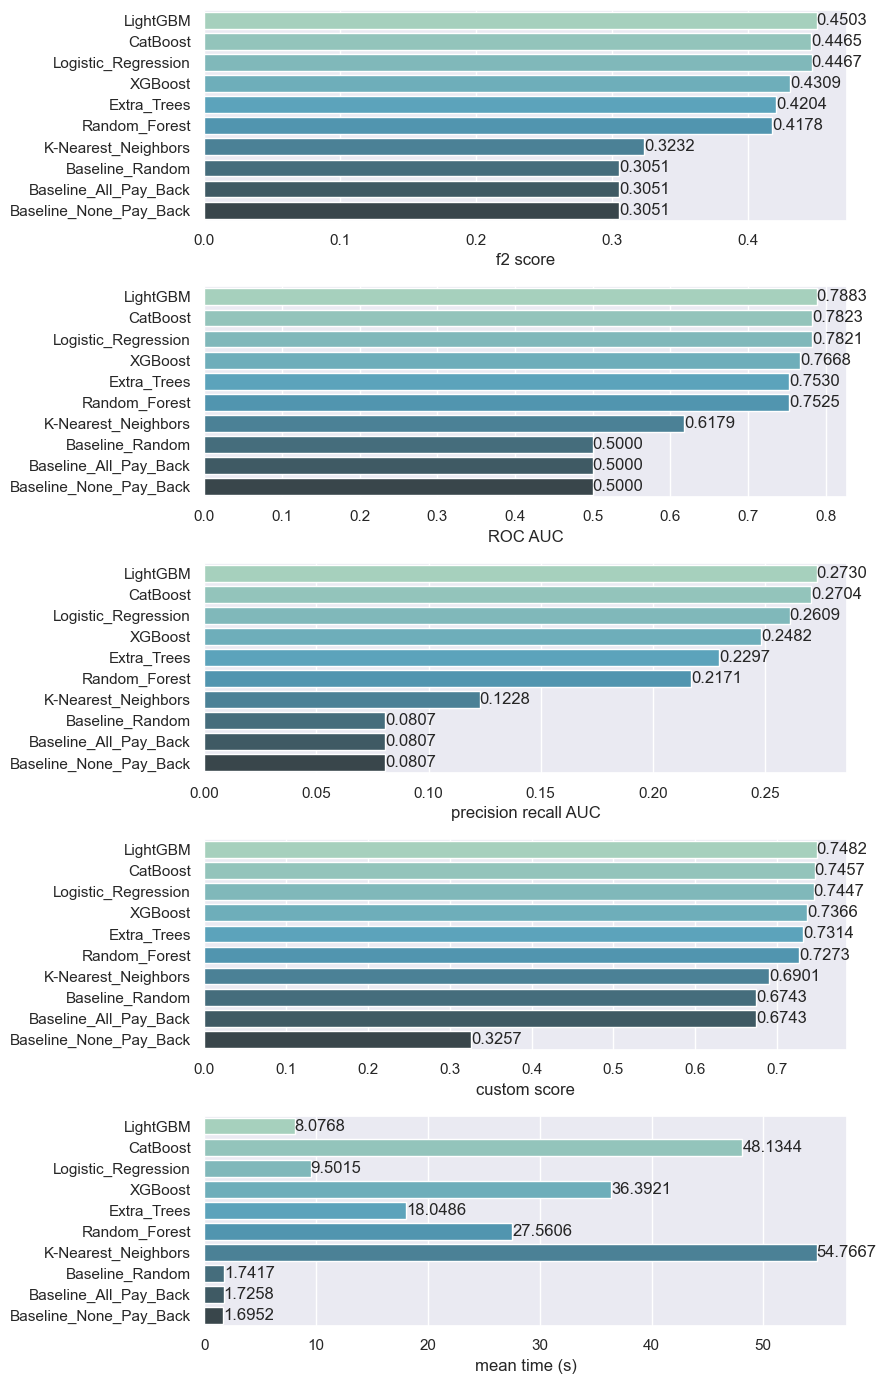

In [122]:
plot_results(results_df_reduit, (9, 14))

In [123]:
mlflow.set_experiment('cross_validation_experiment_features_reduites_mini')

results_df_mini = evaluate_models_cross(models, X_train_fs_mini, y_train, resampling_methods, n_splits=3)
results_df_mini = results_df_mini.sort_values(by='pr_auc_mean', ascending=False)

results_df_mini.to_csv('model_selection_df_1_mini.csv', index=False)

In [124]:
results_df_mini = pd.read_csv('model_selection_df_1_mini.csv')
results_df_mini

,model,resampling,precision_mean,recall_mean,f1_score_mean,f1_score_std,f2_score_mean,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,custom_score_mean,time_mean
0,LightGBM,No_Resampling,0.187356,0.698459,0.334426,0.004175,0.451899,0.788966,0.001304,0.275682,0.002079,0.748478,4.562774
1,CatBoost,No_Resampling,0.213622,0.596737,0.331205,0.004144,0.448950,0.783744,0.002042,0.274768,0.003292,0.746179,35.543428
2,Logistic_Regression,No_Resampling,0.182130,0.694481,0.326639,0.004002,0.444427,0.780385,0.000852,0.259270,0.003424,0.743449,7.164344
3,XGBoost,No_Resampling,0.200992,0.592758,0.317367,0.004117,0.431456,0.769228,0.002181,0.253914,0.003162,0.738653,28.905607
4,Extra_Trees,No_Resampling,0.571963,0.008561,0.309286,0.004477,0.424417,0.757507,0.003645,0.234000,0.003081,0.734347,12.733225
5,Random_Forest,No_Resampling,0.470003,0.013798,0.302461,0.003356,0.423829,0.757537,0.002300,0.224338,0.003428,0.730907,24.166584
6,K-Nearest_Neighbors,No_Resampling,0.289266,0.053732,0.215064,0.000494,0.328580,0.624496,0.001959,0.128605,0.001636,0.694866,34.699192
7,Baseline_Random,No_Resampling,0.080548,0.499547,0.149386,0.000010,0.305099,0.500000,0.000000,0.080723,0.000006,0.674327,1.750990
8,Baseline_All_Pay_Back,No_Resampling,1.000000,0.000000,0.149386,0.000010,0.305099,0.500000,0.000000,0.080723,0.000006,0.674327,1.731026
9,Baseline_None_Pay_Back,No_Resampling,0.080723,1.000000,0.149386,0.000010,0.305099,0.500000,0.000000,0.080723,0.000006,0.325673,1.747302


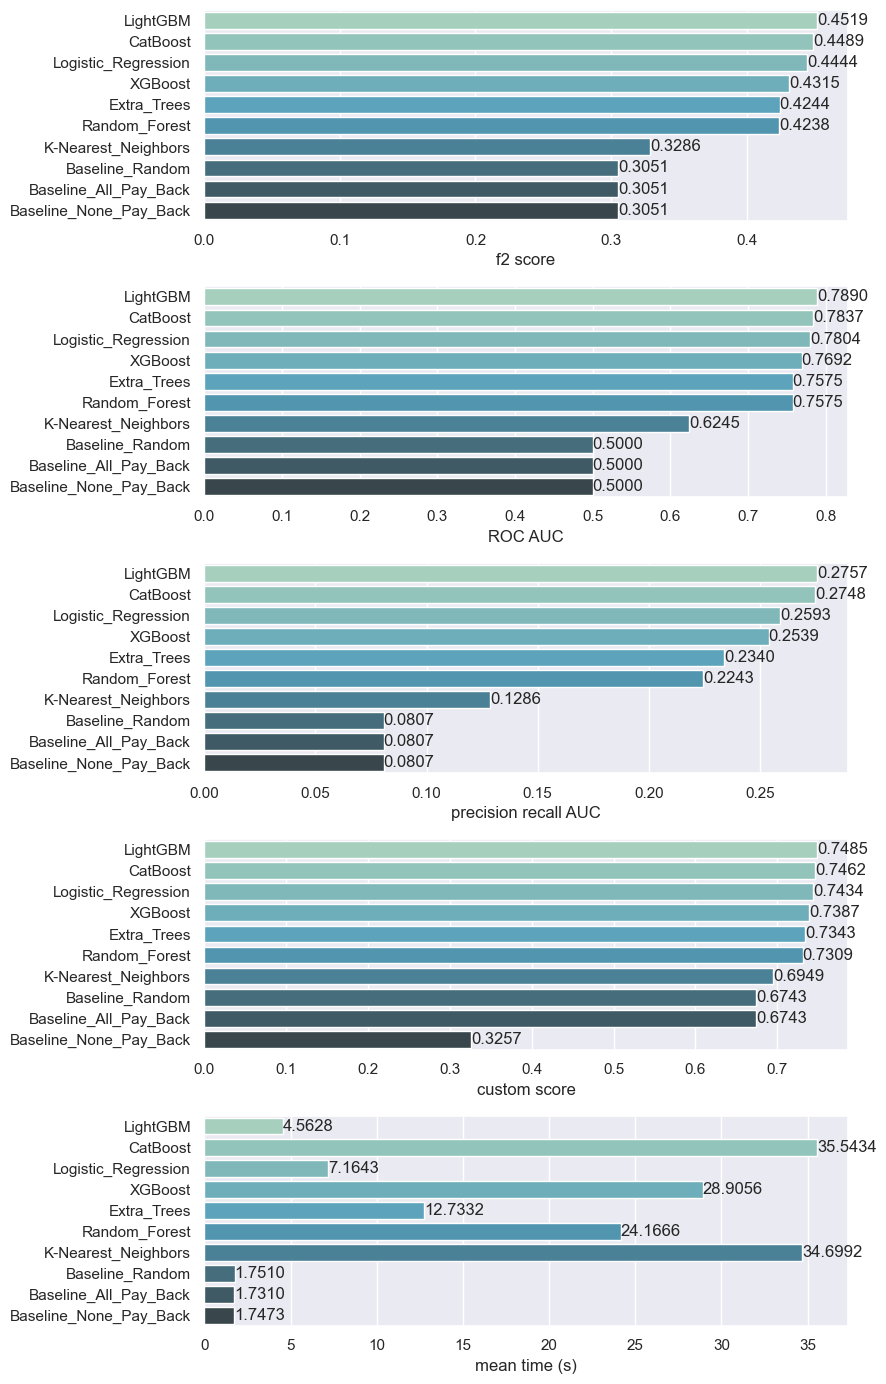

In [125]:
plot_results(results_df_mini, (9, 14))

**Bilan**:

Parmi les trois jeux de données testés lors de la validation croisée, le jeu contenant le nombre de variables le plus faible (151 variables) a permis d’obtenir des scores supérieurs et un temps de calcul réduit par rapport aux autres jeux de données, y compris celui avec 673 variables.

Parmi tous les modèles testés, le modèle ensembliste LightGBM a les scores les plus élevés pour toutes les métriques à l’exception de la précision.
Il a également le temps de calcul le plus court si l’on ignore les modèles naïfs. Avec ce modèle, 69.8 % des mauvais clients sont détectés et 18.7 % des clients prédits comme mauvais sont réellement mauvais.
Outre LightGBM, le modèle ensembliste CatBoost et la régression logistique montrent aussi des scores satisfaisants.

Le score métier que nous avons élaboré ne semble pas être particulièrement pertinent ici. En effet, les différences entre les scores des modèles naïfs et celui du meilleur modèle sont relativement faibles comparées aux écarts observés pour les autres métriques standards.

<br>

---

### <span style='background :#e3e33d' > 3.3 Resampling sur les 3 meilleurs modèles </span>

Nous allons maintenant comparer plusieurs techniques de rééquilibrage des classes pour les trois meilleurs modèles (LightGBM, CatBoost et la régression logistique) :
- **Random OverSampling** : Cette méthode consiste à créer de nouvelles instances de la classe minoritaire en tirant au hasard des exemples existants avec remise. Cela permet d’augmenter la fréquence des exemples de la classe minoritaire dans l’ensemble d’apprentissage ;
- **Random UnderSampling** : Cette méthode consiste à supprimer aléatoirement des instances de la classe majoritaire pour réduire sa fréquence dans l’ensemble d’apprentissage ;
- **SMOTE (Synthetic Minority Over-sampling Technique)** : Cette méthode génère de nouvelles instances de la classe minoritaire en interpolant les caractéristiques des exemples existants. Elle permet d’augmenter la diversité des exemples de la classe minoritaire ;
- **SMOTE combiné avec Random UnderSampling** : Cette approche utilise l’algorithme SMOTE pour augmenter la fréquence de la classe minoritaire et le Random UnderSampling pour réduire la fréquence de la classe majoritaire.

Pour empêcher toute fuite de données, ces techniques de rééchantillonnage ne sont appliquées qu’au jeu d’entrainement lors de la validation croisée à 3 splits.

On enregistre les résultats avec MLFlow.

In [126]:
best_models = {
    'LightGBM': lgb.LGBMClassifier(objective='binary', scale_pos_weight=scale_pos_weight_value, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(auto_class_weights='Balanced', random_state=42, silent=True),
    'Logistic_Regression': make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1))
}

In [127]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbalancedPipeline

resampling_methods = {
    'Class_weight': None,
    'Random_OverSampling': RandomOverSampler(sampling_strategy=0.3, random_state=42),
    'Random_UnderSampling': RandomUnderSampler(sampling_strategy=0.3, random_state=42),
    'SMOTE': SMOTE(sampling_strategy=0.3, random_state=42),
    'SMOTE_Random_UnderSampling': ImbalancedPipeline([
        ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
        ('randomundersampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42))
    ])
}

In [128]:
mlflow.set_experiment('cross_validation_resampling_experiment_full_features')

results_df_2 = evaluate_models_cross(best_models, X_train_fs_lgbm, y_train, resampling_methods, n_splits=3)
results_df_2 = results_df_2.sort_values(by='pr_auc_mean', ascending=False)

results_df_2.to_csv('model_selection_df_2.csv', index=False)

In [129]:
results_df_2 = pd.read_csv('model_selection_df_2.csv')
results_df_2

,model,resampling,precision_mean,recall_mean,f1_score_mean,f1_score_std,f2_score_mean,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,custom_score_mean,time_mean
0,CatBoost,Random_UnderSampling,0.327765,0.325763,0.341073,0.002189,0.458188,0.793530,0.001157,0.281051,0.003114,0.751868,42.625769
1,CatBoost,SMOTE,0.513688,0.056300,0.338989,0.000922,0.451639,0.791700,0.000424,0.276894,0.004187,0.750854,86.453412
2,CatBoost,SMOTE_Random_UnderSampling,0.438296,0.135562,0.338901,0.004160,0.454059,0.791180,0.001506,0.276689,0.004818,0.749475,70.529469
3,LightGBM,Random_OverSampling,0.336400,0.293181,0.336029,0.004233,0.451068,0.789191,0.001562,0.276503,0.004828,0.747878,15.531233
4,LightGBM,Class_weight,0.189014,0.695337,0.335924,0.004308,0.452756,0.789419,0.001873,0.274766,0.002946,0.748414,14.191486
5,CatBoost,Class_weight,0.217875,0.590392,0.333099,0.003644,0.448522,0.784914,0.001310,0.274593,0.003649,0.747224,77.972073
6,LightGBM,Random_UnderSampling,0.321363,0.324857,0.335322,0.001385,0.451451,0.789292,0.001165,0.273652,0.004380,0.748300,7.366693
7,LightGBM,SMOTE_Random_UnderSampling,0.444717,0.112247,0.337191,0.003332,0.450503,0.789522,0.001283,0.273159,0.004598,0.749110,14.185088
8,CatBoost,Random_OverSampling,0.360381,0.239551,0.333393,0.005228,0.450590,0.787006,0.001577,0.272453,0.003964,0.747221,84.618981
9,LightGBM,SMOTE,0.514326,0.032632,0.332762,0.003489,0.450936,0.788941,0.001032,0.271049,0.004103,0.747875,17.155433


In [130]:
results_df_2['model_resampling'] = results_df_2['model'] + '_' + results_df_2['resampling']

results_df_2 = results_df_2.sort_values(by='model_resampling')

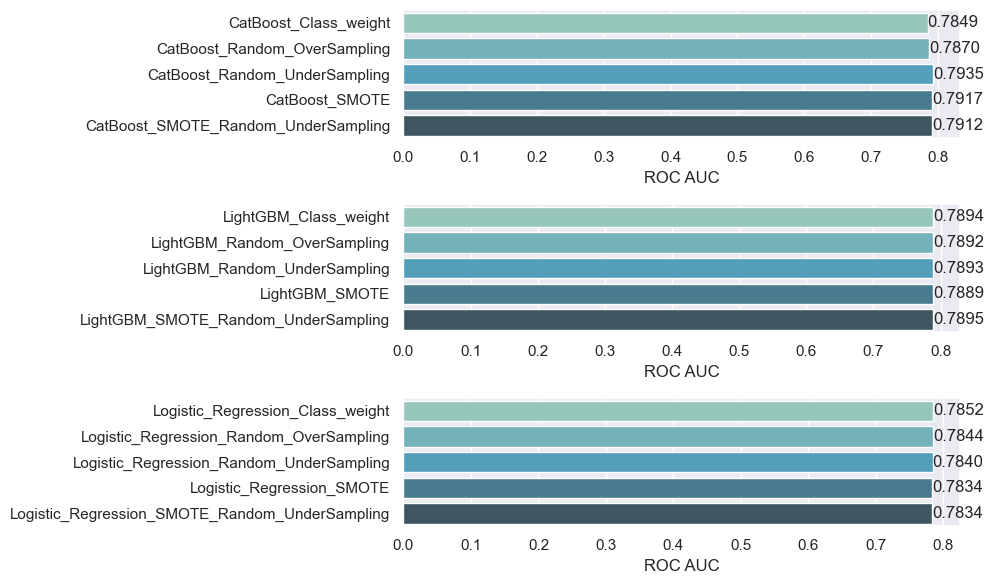

In [131]:
unique_models = results_df_2['model'].unique()

fig, axes = plt.subplots(len(unique_models), 1, figsize=(10, 6))

for idx, m in enumerate(unique_models):
    temp = results_df_2.loc[results_df_2['model'] == m]

    sns.barplot(y=temp['model_resampling'], x=temp["roc_auc_mean"], ax=axes[idx], palette="GnBu_d")
    axes[idx].set(xlabel='ROC AUC', ylabel='')
    axes[idx].bar_label(axes[idx].containers[0], fmt="%.4f", size=12)

plt.tight_layout()
plt.show()

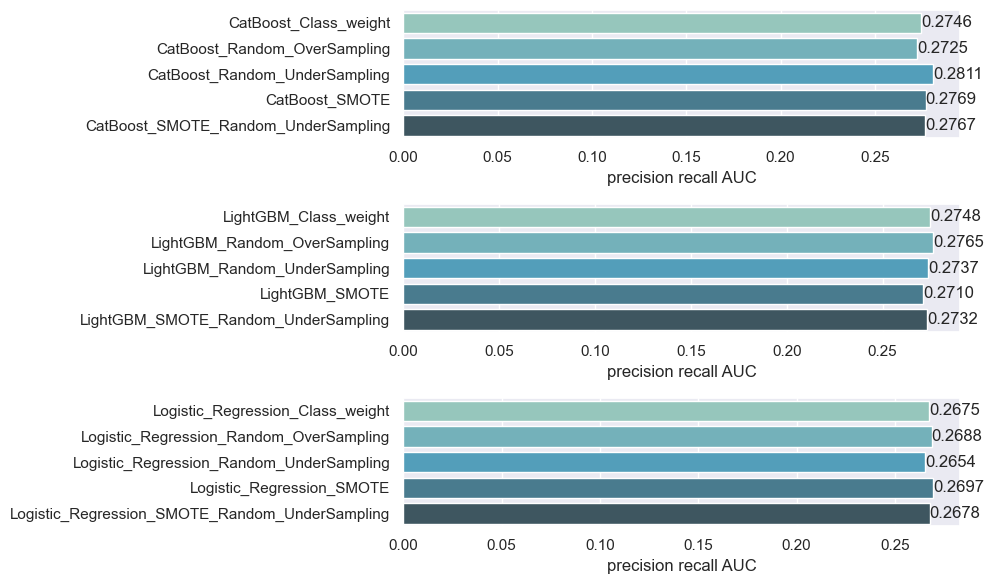

In [132]:
fig, axes = plt.subplots(len(unique_models), 1, figsize=(10, 6))

for idx, m in enumerate(unique_models):
    temp = results_df_2.loc[results_df_2['model'] == m]

    sns.barplot(y=temp['model_resampling'], x=temp["pr_auc_mean"], ax=axes[idx], palette="GnBu_d")
    axes[idx].set(xlabel='precision recall AUC', ylabel='')
    axes[idx].bar_label(axes[idx].containers[0], fmt="%.4f", size=12)

plt.tight_layout()
plt.show()

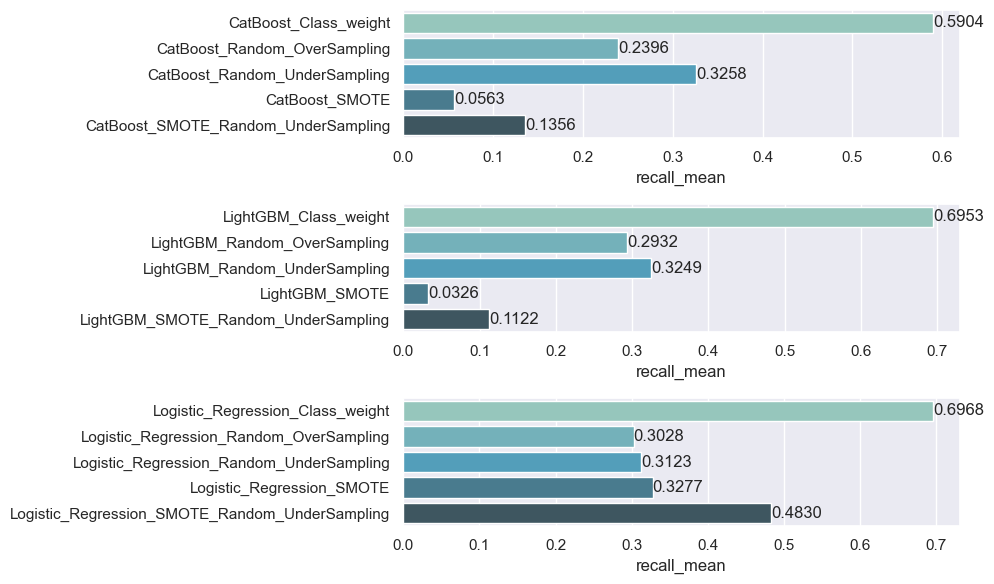

In [133]:
fig, axes = plt.subplots(len(unique_models), 1, figsize=(10, 6))

for idx, m in enumerate(unique_models):
    temp = results_df_2.loc[results_df_2['model'] == m]

    sns.barplot(y=temp['model_resampling'], x=temp["recall_mean"], ax=axes[idx], palette="GnBu_d")
    axes[idx].set(xlabel='recall_mean', ylabel='')
    axes[idx].bar_label(axes[idx].containers[0], fmt="%.4f", size=12)

plt.tight_layout()
plt.show()

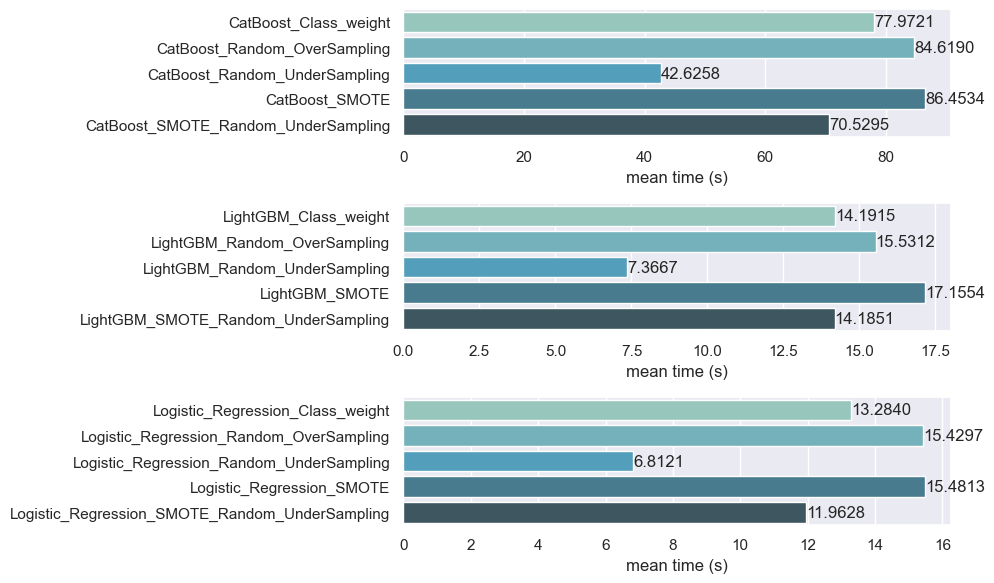

In [134]:
fig, axes = plt.subplots(len(unique_models), 1, figsize=(10, 6))

for idx, m in enumerate(unique_models):
    temp = results_df_2.loc[results_df_2['model'] == m]

    sns.barplot(y=temp['model_resampling'], x=temp["time_mean"], ax=axes[idx], palette="GnBu_d")
    axes[idx].set(xlabel='mean time (s)', ylabel='')
    axes[idx].bar_label(axes[idx].containers[0], fmt="%.4f", size=12)

plt.tight_layout()
plt.show()

In [135]:
mlflow.set_experiment('cross_validation_resampling_experiment_features_reduites_cumul')

results_df_2_reduit = evaluate_models_cross(best_models, X_train_fs_cumul, y_train, resampling_methods, n_splits=3)
results_df_2_reduit = results_df_2_reduit.sort_values(by='pr_auc_mean', ascending=False)

results_df_2_reduit.to_csv('model_selection_df_2_reduit.csv', index=False)

In [136]:
results_df_2_reduit = pd.read_csv('model_selection_df_2_reduit.csv')
results_df_2_reduit

,model,resampling,precision_mean,recall_mean,f1_score_mean,f1_score_std,f2_score_mean,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,custom_score_mean,time_mean
0,CatBoost,Random_UnderSampling,0.325703,0.322993,0.338903,0.001742,0.454147,0.791565,0.001291,0.277727,0.001994,0.749761,27.485973
1,LightGBM,Random_OverSampling,0.336192,0.291772,0.336342,0.002361,0.449492,0.788419,0.001022,0.273952,0.004006,0.748479,8.480814
2,CatBoost,SMOTE_Random_UnderSampling,0.420372,0.137124,0.334844,0.003625,0.450940,0.788330,0.001526,0.273390,0.002137,0.747758,41.078762
3,LightGBM,Class_weight,0.187072,0.694733,0.334345,0.004267,0.450310,0.788283,0.000919,0.272992,0.002301,0.748209,7.299224
4,LightGBM,Random_UnderSampling,0.318394,0.323799,0.333937,0.002180,0.450792,0.788142,0.000925,0.272924,0.004000,0.747459,4.129794
5,CatBoost,SMOTE,0.510687,0.057257,0.332592,0.001557,0.448385,0.787933,0.000373,0.272002,0.003934,0.747595,50.313017
6,CatBoost,Class_weight,0.214822,0.591701,0.330207,0.004753,0.446547,0.782269,0.002314,0.270414,0.004294,0.745745,45.437773
7,LightGBM,SMOTE_Random_UnderSampling,0.423661,0.119096,0.332184,0.005674,0.449488,0.786807,0.001981,0.266857,0.005186,0.747058,6.924302
8,LightGBM,SMOTE,0.494917,0.032481,0.331037,0.005149,0.449489,0.786938,0.001520,0.266525,0.002655,0.746259,9.180882
9,CatBoost,Random_OverSampling,0.353791,0.235220,0.329039,0.001666,0.447479,0.783636,0.002623,0.266421,0.003452,0.744588,49.582167


In [137]:
results_df_2_reduit['model_resampling'] = results_df_2_reduit['model'] + '_' + results_df_2_reduit['resampling']

results_df_2_reduit = results_df_2_reduit.sort_values(by='model_resampling')

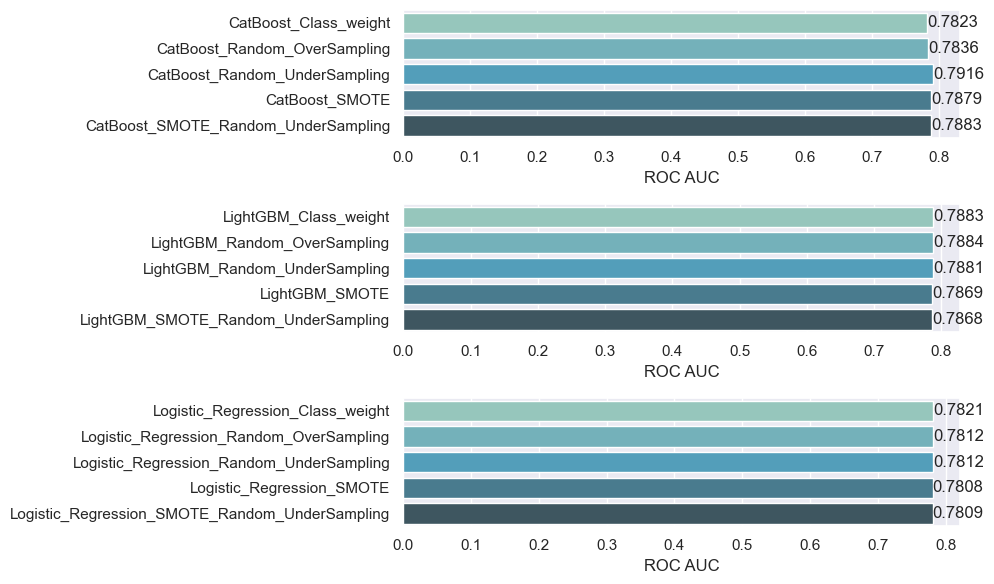

In [138]:
unique_models = results_df_2_reduit['model'].unique()

fig, axes = plt.subplots(len(unique_models), 1, figsize=(10, 6))

for idx, m in enumerate(unique_models):
    temp = results_df_2_reduit.loc[results_df_2_reduit['model'] == m]

    sns.barplot(y=temp['model_resampling'], x=temp["roc_auc_mean"], ax=axes[idx], palette="GnBu_d")
    axes[idx].set(xlabel='ROC AUC', ylabel='')
    axes[idx].bar_label(axes[idx].containers[0], fmt="%.4f", size=12)

plt.tight_layout()
plt.show()

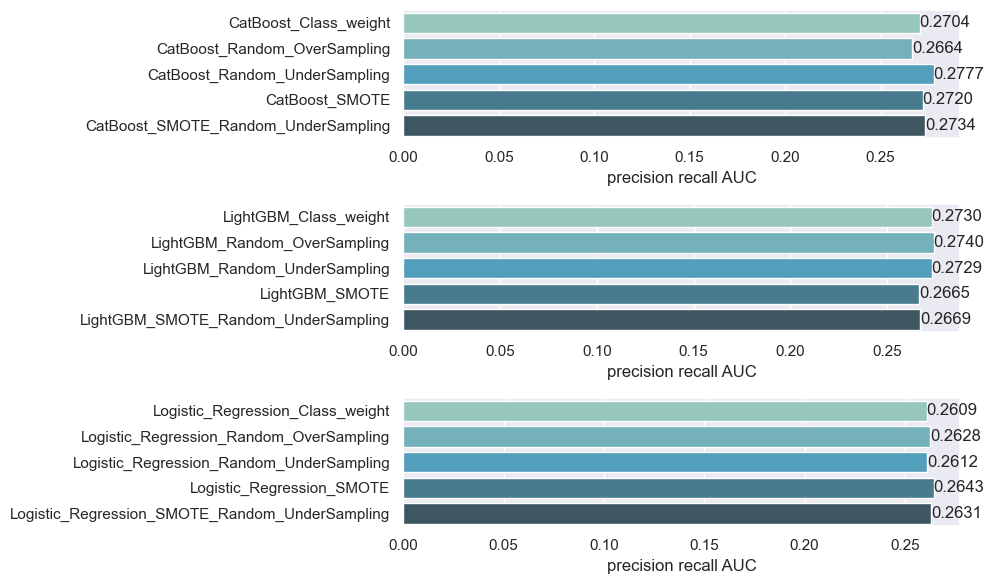

In [139]:
fig, axes = plt.subplots(len(unique_models), 1, figsize=(10, 6))

for idx, m in enumerate(unique_models):
    temp = results_df_2_reduit.loc[results_df_2_reduit['model'] == m]

    sns.barplot(y=temp['model_resampling'], x=temp["pr_auc_mean"], ax=axes[idx], palette="GnBu_d")
    axes[idx].set(xlabel='precision recall AUC', ylabel='')
    axes[idx].bar_label(axes[idx].containers[0], fmt="%.4f", size=12)

plt.tight_layout()
plt.show()

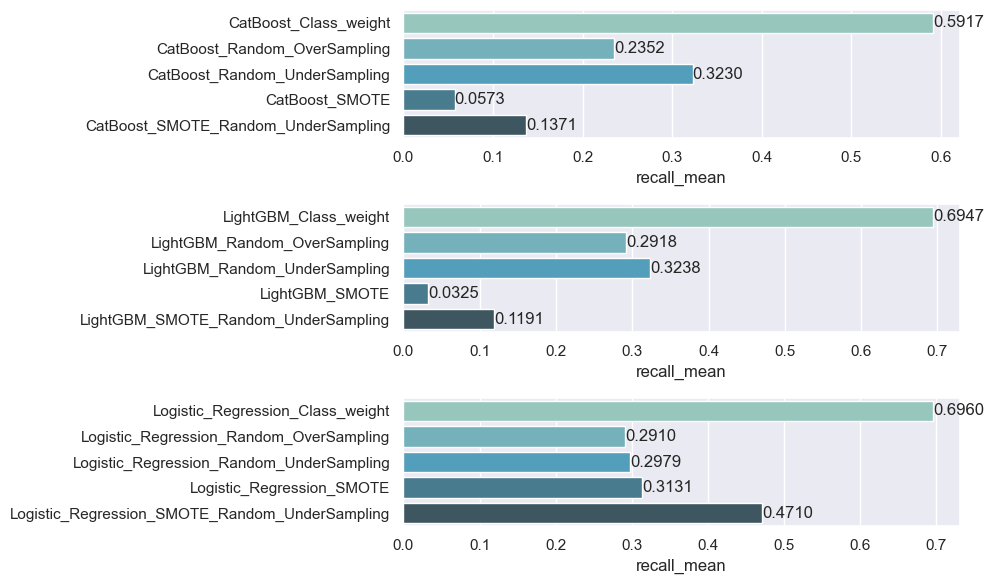

In [140]:
fig, axes = plt.subplots(len(unique_models), 1, figsize=(10, 6))

for idx, m in enumerate(unique_models):
    temp = results_df_2_reduit.loc[results_df_2_reduit['model'] == m]

    sns.barplot(y=temp['model_resampling'], x=temp["recall_mean"], ax=axes[idx], palette="GnBu_d")
    axes[idx].set(xlabel='recall_mean', ylabel='')
    axes[idx].bar_label(axes[idx].containers[0], fmt="%.4f", size=12)

plt.tight_layout()
plt.show()

In [141]:
mlflow.set_experiment('cross_validation_resampling_experiment_features_reduites_mini')

results_df_2_mini = evaluate_models_cross(best_models, X_train_fs_mini, y_train, resampling_methods, n_splits=3)
results_df_2_mini = results_df_2_mini.sort_values(by='pr_auc_mean', ascending=False)

results_df_2_mini.to_csv('model_selection_df_2_mini.csv', index=False)

In [142]:
results_df_2_mini = pd.read_csv('model_selection_df_2_mini.csv')
results_df_2_mini

,model,resampling,precision_mean,recall_mean,f1_score_mean,f1_score_std,f2_score_mean,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,custom_score_mean,time_mean
0,CatBoost,Random_UnderSampling,0.326995,0.325864,0.341589,0.001392,0.454823,0.793004,0.001046,0.280563,0.001918,0.751193,19.247930
1,LightGBM,Random_OverSampling,0.337725,0.296253,0.336114,0.002825,0.451105,0.789481,0.001482,0.276943,0.004250,0.748077,4.826250
2,LightGBM,Class_weight,0.187356,0.698459,0.334426,0.004175,0.451899,0.788966,0.001304,0.275682,0.002079,0.748478,4.275702
3,LightGBM,Random_UnderSampling,0.319444,0.322238,0.335628,0.002806,0.451102,0.788782,0.001031,0.275079,0.003990,0.748279,2.961775
4,CatBoost,Class_weight,0.213622,0.596737,0.331205,0.004144,0.448950,0.783744,0.002042,0.274768,0.003292,0.746179,30.878731
5,CatBoost,Random_OverSampling,0.354217,0.240508,0.330526,0.001254,0.448762,0.785023,0.001226,0.269805,0.003258,0.745681,33.505190
6,CatBoost,SMOTE_Random_UnderSampling,0.404454,0.156662,0.330538,0.001139,0.449071,0.786125,0.001521,0.267579,0.000660,0.745922,28.633102
7,CatBoost,SMOTE,0.472177,0.065415,0.328731,0.000290,0.447546,0.785436,0.001210,0.266515,0.001848,0.745831,34.096157
8,Logistic_Regression,SMOTE,0.313211,0.310656,0.327018,0.003672,0.442235,0.779154,0.000517,0.261771,0.003366,0.743649,7.505686
9,Logistic_Regression,Random_OverSampling,0.326418,0.286686,0.326965,0.003440,0.443796,0.779536,0.000910,0.261001,0.003624,0.743684,7.518346


In [143]:
results_df_2_mini['model_resampling'] = results_df_2_mini['model'] + '_' + results_df_2_mini['resampling']

results_df_2_mini = results_df_2_mini.sort_values(by='model_resampling')

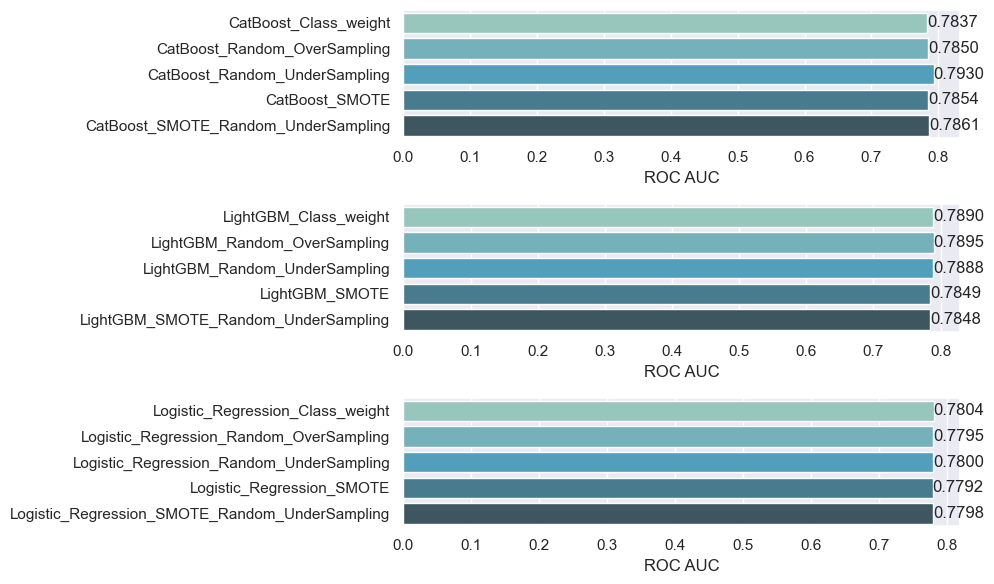

In [144]:
unique_models = results_df_2_mini['model'].unique()

fig, axes = plt.subplots(len(unique_models), 1, figsize=(10, 6))

for idx, m in enumerate(unique_models):
    temp = results_df_2_mini.loc[results_df_2_mini['model'] == m]

    sns.barplot(y=temp['model_resampling'], x=temp["roc_auc_mean"], ax=axes[idx], palette="GnBu_d")
    axes[idx].set(xlabel='ROC AUC', ylabel='')
    axes[idx].bar_label(axes[idx].containers[0], fmt="%.4f", size=12)

plt.tight_layout()
plt.show()

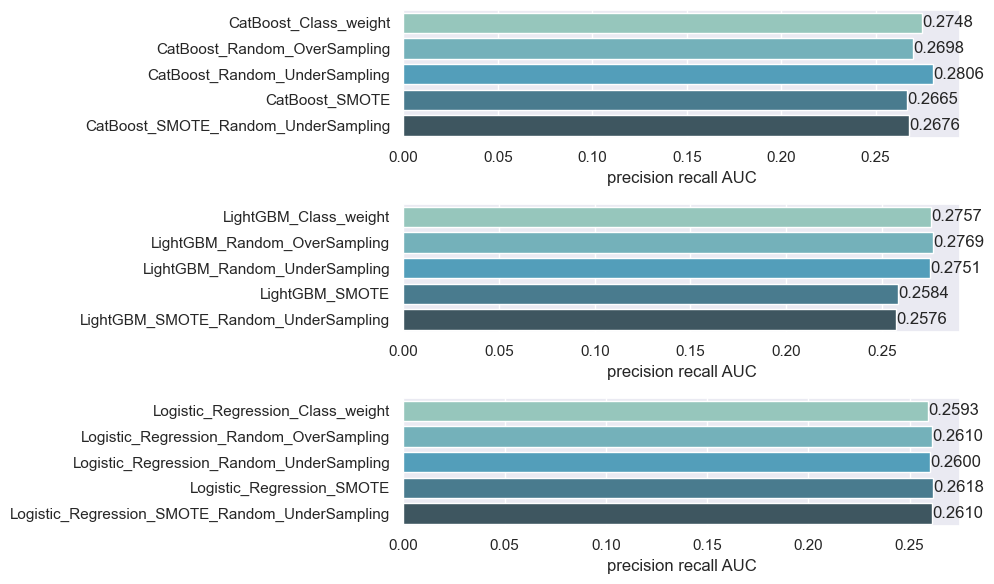

In [145]:
fig, axes = plt.subplots(len(unique_models), 1, figsize=(10, 6))

for idx, m in enumerate(unique_models):
    temp = results_df_2_mini.loc[results_df_2_mini['model'] == m]

    sns.barplot(y=temp['model_resampling'], x=temp["pr_auc_mean"], ax=axes[idx], palette="GnBu_d")
    axes[idx].set(xlabel='precision recall AUC', ylabel='')
    axes[idx].bar_label(axes[idx].containers[0], fmt="%.4f", size=12)

plt.tight_layout()
plt.show()

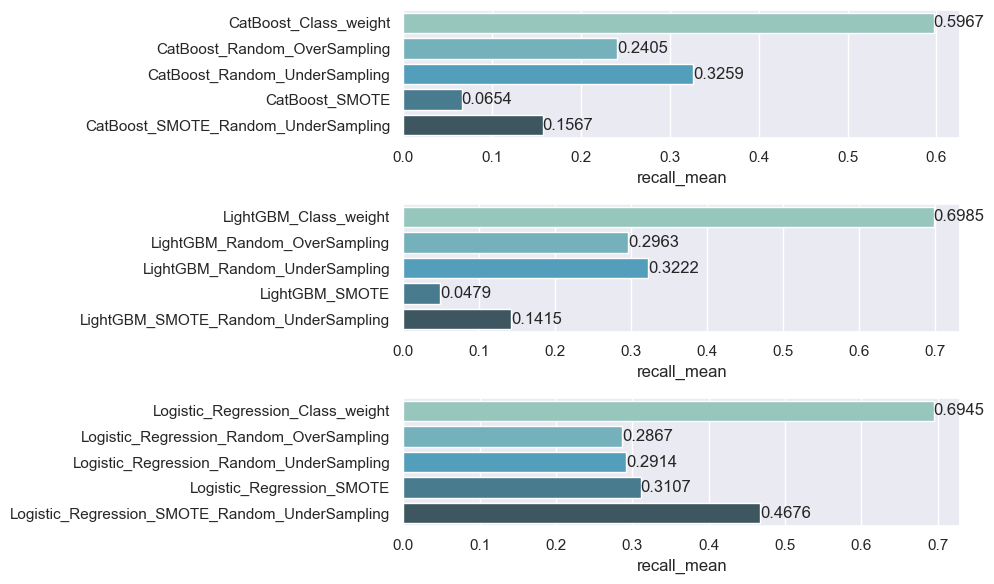

In [146]:
fig, axes = plt.subplots(len(unique_models), 1, figsize=(10, 6))

for idx, m in enumerate(unique_models):
    temp = results_df_2_mini.loc[results_df_2_mini['model'] == m]

    sns.barplot(y=temp['model_resampling'], x=temp["recall_mean"], ax=axes[idx], palette="GnBu_d")
    axes[idx].set(xlabel='recall_mean', ylabel='')
    axes[idx].bar_label(axes[idx].containers[0], fmt="%.4f", size=12)

plt.tight_layout()
plt.show()

**Bilan** :

Pour chacun des trois modèles, les méthodes de rééchantillonnage ont permis d’obtenir des scores légèrement plus élevés que les méthodes de pondération des classes, et ce, pour la plupart des métriques d’évaluation à l’exception du rappel.
Par exemple, l’utilisation du Random OverSampling pour le modèle LightGBM a permis d’augmenter le AUC precision-recall de 0.27567 à 0.2769 mais a diminué le rappel de 0.698 à 0.296.

Notre objectif premier étant de détecter le plus de mauvais clients possible, l’utilisation de ces méthodes de rééchantillonnage n’est pas opportun ici.

En conséquence, LightGBM couplé à la pondération des classes apparait indiscutablement comme le meilleur choix de modèle pour notre problème de classification car il allie rapidité et performance.

Nous utiliserons le jeu réduit à 151 variables qui a permis d’obtenir les meilleurs scores ainsi que le temps de calcul le plus faible.

<br>

---

##  <span style='background :#96e773' > 4. Optimisation des hyperparamètres </span>
### <span style='background :#e3e33d' > 4.1 Optuna </span>

Pour optimiser notre modèle, on utilise la librairie Optuna avec la métrique AUC Precision-Recall. On enregistre les résultats avec MLFlow, les études sous format pickle et le modèle optimisé sous format joblib.

In [147]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y, scoring='average_precision'):

    with mlflow.start_run(run_name=f"trial_{trial.number}"):

        n_splits = 3
        stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Define the hyperparameters to optimize
        params = {
            "boosting_type": trial.suggest_categorical("LightGBM__boosting_type", ["gbdt", "goss"]),
            "num_leaves": trial.suggest_int("LightGBM__num_leaves", 2, 256),
            "max_depth": trial.suggest_int("LightGBM__max_depth", 1, 8),
            "min_child_samples": trial.suggest_int("LightGBM__min_child_samples", 5, 100),
            "min_child_weight": trial.suggest_loguniform("LightGBM__min_child_weight", 1e-5, 1e-2),
            "subsample": trial.suggest_uniform("LightGBM__subsample", 0.1, 1.0),
            "colsample_bytree": trial.suggest_uniform("LightGBM__colsample_bytree", 0.1, 1.0),
            "reg_alpha": trial.suggest_loguniform("LightGBM__reg_alpha", 1e-8, 1e-2),
            "reg_lambda": trial.suggest_loguniform("LightGBM__reg_lambda", 1e-8, 1e-2),
            "learning_rate": trial.suggest_loguniform("LightGBM__learning_rate", 1e-2, 3e-2),
            "n_estimators": trial.suggest_int("LightGBM__n_estimators", 100, 2000)}

        pruning_callback = LightGBMPruningCallback(trial, "average_precision")
        lgbm_clf = lgb.LGBMClassifier(objective='binary', scale_pos_weight=scale_pos_weight_value, random_state=42, n_jobs=-1, **params, callbacks=[pruning_callback])

        scores = cross_val_score(lgbm_clf, X, y, scoring=scoring, cv=stratified_kfold, n_jobs=-1)

        # Log hyperparameters to MLflow
        for key, value in params.items():
            mlflow.log_param(key, value)

        # Log the average score to MLflow
        mlflow.log_metric("average_score", -np.mean(scores))

        # Enable autologging for LightGBM
        mlflow.lightgbm.autolog()

        return -np.mean(scores)  # Optuna minimizes the objective function, so we return the negative of the average score

In [148]:
from optuna.samplers import TPESampler

mlflow.set_experiment('optuna_tuning_experiment_1')

# Create a study with sampler and pruner
sampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(sampler=sampler, pruner=pruner, direction='minimize')
study.optimize(lambda trial: objective(trial, X_train_fs_mini, y_train), n_trials=50, timeout=None)

# Print the best set of hyperparameters and the corresponding score
print("Best trial:")
trial = study.best_trial
print("  Score:", -trial.value)
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Create the final model with the best set of hyperparameters
best_params = {k[10:]: v for k, v in trial.params.items()}  # Remove the "LightGBM__" prefix
best_model = lgb.LGBMClassifier(objective='binary', scale_pos_weight=scale_pos_weight_value, random_state=42, n_jobs=-1, **best_params)

In [149]:
# Log the best model
with mlflow.start_run(run_name="best_model"):
    mlflow.lightgbm.log_model(best_model, "model")
    mlflow.log_params(best_params)

In [150]:
import joblib

# Save the study
joblib.dump(study, "study.pkl")

In [151]:
# Load the study
study = joblib.load("study.pkl")

# Print the best set of hyperparameters and the corresponding score
print("Best trial:")
trial = study.best_trial
print("  Score:", -trial.value)
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Create the final model with the best set of hyperparameters
best_params = {k[10:]: v for k, v in trial.params.items()}  # Remove the "LightGBM__" prefix
best_model = lgb.LGBMClassifier(objective='binary', scale_pos_weight=scale_pos_weight_value, random_state=42, n_jobs=-1, **best_params)

Best trial:
  Score: 0.28638179774854083
  Params:
    LightGBM__boosting_type: goss
    LightGBM__num_leaves: 239
    LightGBM__max_depth: 5
    LightGBM__min_child_samples: 82
    LightGBM__min_child_weight: 2.0821995046104252e-05
    LightGBM__subsample: 0.4085797034730706
    LightGBM__colsample_bytree: 0.5302562259666418
    LightGBM__reg_alpha: 0.00822977661840845
    LightGBM__reg_lambda: 0.00010327856809987313
    LightGBM__learning_rate: 0.010056274263506138
    LightGBM__n_estimators: 1871


On effectue une deuxième recherche d'hyperparamètres en réduisant la plage de recherche.

In [152]:
# Save the model
joblib.dump(best_model, "model_study_1.joblib")

In [153]:
def objective(trial, X, y, scoring='average_precision'):

    with mlflow.start_run(run_name=f"trial_{trial.number}"):

        n_splits = 3
        stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Define the hyperparameters to optimize
        params = {
            "boosting_type": trial.suggest_categorical("LightGBM__boosting_type", ["goss"]),
            "num_leaves": trial.suggest_int("LightGBM__num_leaves", 30, 200),
            "max_depth": trial.suggest_int("LightGBM__max_depth", 4, 6),
            "min_child_samples": trial.suggest_int("LightGBM__min_child_samples", 5, 100),
            "min_child_weight": trial.suggest_loguniform("LightGBM__min_child_weight", 1e-5, 1e-2),
            "subsample": trial.suggest_uniform("LightGBM__subsample", 0.2, 0.9),
            "colsample_bytree": trial.suggest_uniform("LightGBM__colsample_bytree", 0.2, 0.9),
            "reg_alpha": trial.suggest_loguniform("LightGBM__reg_alpha", 1e-8, 1e-6),
            "reg_lambda": trial.suggest_loguniform("LightGBM__reg_lambda", 1e-8, 1e-2),
            "learning_rate": trial.suggest_loguniform("LightGBM__learning_rate", 5e-3, 3e-2),
            "n_estimators": trial.suggest_int("LightGBM__n_estimators", 1000, 2000)
        }

        pruning_callback = LightGBMPruningCallback(trial, "average_precision")
        lgbm_clf = lgb.LGBMClassifier(objective='binary', scale_pos_weight=scale_pos_weight_value, random_state=42, n_jobs=-1, **params, callbacks=[pruning_callback])

        scores = cross_val_score(lgbm_clf, X, y, scoring=scoring, cv=stratified_kfold, n_jobs=-1)

        # Log hyperparameters to MLflow
        for key, value in params.items():
            mlflow.log_param(key, value)

        # Log the average score to MLflow
        mlflow.log_metric("average_score", -np.mean(scores))

        # Enable autologging for LightGBM
        mlflow.lightgbm.autolog()

        return -np.mean(scores)  # Optuna minimizes the objective function, so we return the negative of the average score

In [154]:
mlflow.set_experiment('optuna_tuning_experiment_2')

# Create a study with sampler and pruner
sampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner()
study_2 = optuna.create_study(sampler=sampler, pruner=pruner, direction='minimize')
study_2.optimize(lambda trial: objective(trial, X_train_fs_mini, y_train), n_trials=50, timeout=None)

# Print the best set of hyperparameters and the corresponding score
print("Best trial:")
trial = study_2.best_trial
print("  Score:", -trial.value)
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Create the final model with the best set of hyperparameters
best_params = {k[10:]: v for k, v in trial.params.items()}  # Remove the "LightGBM__" prefix
best_model = lgb.LGBMClassifier(objective='binary', scale_pos_weight=scale_pos_weight_value, random_state=42, n_jobs=-1, **best_params)

In [155]:
# Log the best model
with mlflow.start_run(run_name="best_model"):
    mlflow.lightgbm.log_model(best_model, "model")
    mlflow.log_params(best_params)

In [156]:
# Save the study
joblib.dump(study_2, "study_2.pkl")

In [157]:
# Load the study
study_2 = joblib.load("study_2.pkl")

# Print the best set of hyperparameters and the corresponding score
print("Best trial:")
trial = study_2.best_trial
print("  Score:", -trial.value)
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Create the final model with the best set of hyperparameters
best_params = {k[10:]: v for k, v in trial.params.items()}  # Remove the "LightGBM__" prefix
best_model = lgb.LGBMClassifier(objective='binary', scale_pos_weight=scale_pos_weight_value, random_state=42, n_jobs=-1, **best_params)

Best trial:
  Score: 0.287085882629342
  Params:
    LightGBM__boosting_type: goss
    LightGBM__num_leaves: 111
    LightGBM__max_depth: 5
    LightGBM__min_child_samples: 94
    LightGBM__min_child_weight: 5.166050203224009e-05
    LightGBM__subsample: 0.3813042668591913
    LightGBM__colsample_bytree: 0.3480218925038123
    LightGBM__reg_alpha: 2.2435897639005464e-08
    LightGBM__reg_lambda: 0.0002665182934762796
    LightGBM__learning_rate: 0.01362241204516248
    LightGBM__n_estimators: 1961


L’optimisation des hyperparamètres a permis d’augmenter l’AUC Precision-Recall de 0.2756 à 0.2871.

In [158]:
# Save the model
joblib.dump(best_model, "model_study_2.joblib")

In [159]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, cv=None, train_sizes=np.linspace(0.1, 1.0, 10), scoring='average_precision'):

    if cv is None:
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring, n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    sns.set_style("darkgrid")

    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    sns.lineplot(x=train_sizes, y=train_scores_mean, label="Train", marker="o")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="blue")

    sns.lineplot(x=train_sizes, y=validation_scores_mean, label="Validation", marker="o")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="orange")

    plt.legend(loc="best")
    plt.show()

In [160]:
best_model_opti = joblib.load("model_study_2.joblib")
best_model_opti

LGBMClassifier(boosting_type='goss', colsample_bytree=0.3480218925038123,
               learning_rate=0.01362241204516248, max_depth=5,
               min_child_samples=94, min_child_weight=5.166050203224009e-05,
               n_estimators=1961, num_leaves=111, objective='binary',
               random_state=42, reg_alpha=2.2435897639005464e-08,
               reg_lambda=0.0002665182934762796,
               scale_pos_weight=11.388105549400745,
               subsample=0.3813042668591913)

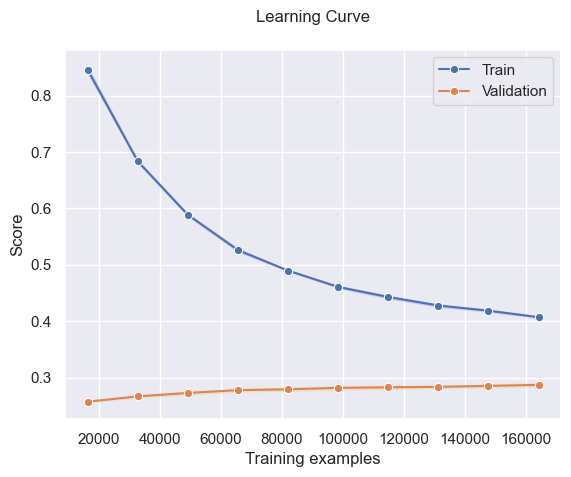

In [161]:
plot_learning_curve(best_model_opti, X_train_fs_mini, y_train, scoring='average_precision')

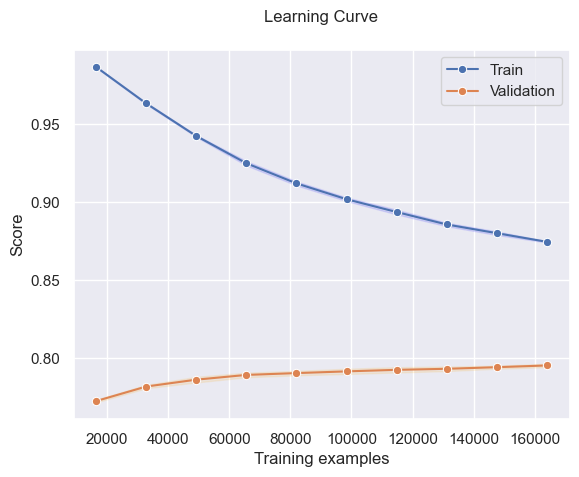

In [162]:
plot_learning_curve(best_model_opti, X_train_fs_mini, y_train, scoring='roc_auc')

L'écart entre les courbes d'apprentissage du jeu d'entrainement et de validation diminue avec le nombre d'exemples d'entrainement. Cela signifie qu'en ajoutant des nouvelles données le modèle pourrait améliorer sa capacité de généralisation et ses performances.

<br>

---

### <span style='background :#e3e33d' > 4.2 Évaluation du meilleur modèle optimisé sur le jeu de validation </span>

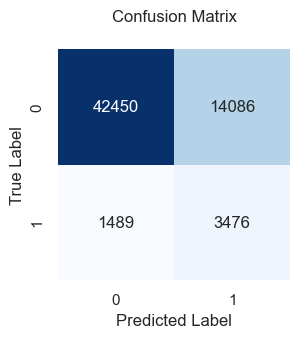

In [163]:
best_model_opti.fit(X_train_fs_mini, y_train)
print_confusion_matrix(best_model_opti, X_valid_fs_mini, y_validation)

3476 mauvais clients ont été correctement identifiés. 1489 mauvais clients ont été classés à tort comme de bons clients.
42450 bons clients ont été correctement identifiés. 14086 bons clients ont été classés à tort comme de mauvais clients.

In [164]:
experiment_name = 'validation_scores_experiment'
mlflow.set_experiment(experiment_name)
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

On calcule les différents scores sur le jeu de validation.

In [165]:
# Make predictions on the validation set
y_pred_proba = best_model_opti.predict_proba(X_valid_fs_mini)[:, 1]
y_pred = best_model_opti.predict(X_valid_fs_mini)

# Find the optimal threshold
thresholds = np.arange(0, 1, 0.01)

with mlflow.start_run(run_name="validation_scores", experiment_id=experiment_id):

    # Calculate the evaluation metrics
    precision = precision_score(y_validation, y_pred, zero_division=1.0)
    recall = recall_score(y_validation, y_pred)
    f1, _ = find_optimal_threshold(y_validation, y_pred_proba, thresholds, score_func=f1_score)
    f2, best_threshold_f2 = find_optimal_threshold(y_validation, y_pred_proba, thresholds, score_func=fbeta_score)
    custom, _ = find_optimal_threshold(y_validation, y_pred_proba, thresholds, score_func=custom_score)
    roc_auc = roc_auc_score(y_validation, y_pred_proba)
    pr_auc = average_precision_score(y_validation, y_pred_proba)

    # Log the evaluation metrics
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("f2", f2)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("pr_auc", pr_auc)
    mlflow.log_metric("custom_score", custom)

    # Log the best model
    mlflow.lightgbm.log_model(best_model, "model")

    # Register the model to the MLflow registry
    run_id = mlflow.active_run().info.run_id
    model_uri = f"runs:/{run_id}/model"
    registered_model_name = "modèle_lgbtm_optimised_training_set"
    mlflow.register_model(model_uri, registered_model_name)

# Print the evaluation metrics
print(f"precision: {format(precision, '.4f')}")
print(f"recall: {format(recall, '.4f')}")
print(f"f1: {format(f1, '.4f')}")
print(f"f2: {format(f2, '.4f')}")
print(f"roc_auc: {format(roc_auc, '.4f')}")
print(f"pr_auc: {format(pr_auc, '.4f')}")
print(f"custom score: {format(custom, '.4f')}")

precision: 0.1979
recall: 0.7001
f1: 0.3478
f2: 0.4644
roc_auc: 0.7956
pr_auc: 0.2899
custom score: 0.7552


Le modèle optimisé parvient à détecter 70 % des mauvais clients, et 19,8 % des clients prédits comme mauvais s’avèrent effectivement l’être. L’AUC Precision-Recall atteint une valeur de 0,2899.
Ces performances surpassent celles observées lors de la validation croisée sur le jeu d’entraînement, mettant en évidence la bonne capacité de généralisation du modèle.

In [166]:
print(best_threshold_f2)

0.5


Le seuil de prédiction permettant d'optimiser le score F2 est égal à 0.5 (seuil par défaut). C'est le seuil qu'on utilisera pour classer un client comme bon ou mauvais.
On utilise le score F2 car il permet de mettre davantage l’accent sur le rappel que sur la précision.

<br>

---

### <span style='background :#e3e33d' > 4.3 Prédiction sur le jeu de test </span>

Avant d’effectuer les prédictions sur le jeu de test, on réentraine le modèle en combinant les jeux d’entraînement et de validation.

In [167]:
experiment_name = 'final_experiment_test_prediction'
mlflow.set_experiment(experiment_name)
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

In [168]:
temp_total = X_train_fs_mini.append(X_valid_fs_mini)
temp_total_y = y_train.append(y_validation)

On met à jour les poids pour la pondération des classes.

In [169]:
best_model.scale_pos_weight = (temp_total_y == 0).sum() / (temp_total_y == 1).sum()

In [170]:
with mlflow.start_run(run_name="final_fit_train_validation", experiment_id=experiment_id):

    best_model_opti.fit(temp_total, temp_total_y)

LGBMClassifier(boosting_type='goss', colsample_bytree=0.3480218925038123,
               learning_rate=0.01362241204516248, max_depth=5,
               min_child_samples=94, min_child_weight=5.166050203224009e-05,
               n_estimators=1961, num_leaves=111, objective='binary',
               random_state=42, reg_alpha=2.2435897639005464e-08,
               reg_lambda=0.0002665182934762796,
               scale_pos_weight=11.388105549400745,
               subsample=0.3813042668591913)

On sauvegarde le modèle entrainé sous format joblib. Ce modèle sera utilisé pour l'API.

In [171]:
joblib.dump(best_model_opti, "model_prediction.joblib")

['model_prediction.joblib']

In [172]:
# Log the best model
mlflow.lightgbm.log_model(best_model_opti, "model")

# Register the model to the MLflow registry
run_id = mlflow.active_run().info.run_id
model_uri = f"runs:/{run_id}/model"
registered_model_name = "final_lgbtm_model_fitted"
mlflow.register_model(model_uri, registered_model_name)

On effectue les prédictions que l'on enregistre au format csv puis on les soumet sur Kaggle.

In [173]:
result_temp = best_model_opti.predict_proba(test_fs_mini.drop(columns='SK_ID_CURR'))[:, 1]

In [174]:
sub_temp = pd.DataFrame()
sub_temp['SK_ID_CURR'] = test_fs_mini['SK_ID_CURR'].astype('int32')
sub_temp['TARGET'] = result_temp

In [175]:
sub_temp.to_csv('submission_lgbm_opti.csv', index = False)

On obtient les scores suivants (AUC ROC) :

**Public Score:** 0.7898
**Private Score:** 0.79118

<br>

---

##  <span style='background :#96e773' > 5. Interprétation du modèle avec SHAP </span>

Pour interpréter notre modèle on utilise la librairie SHAP.

In [176]:
import shap

explainer = shap.Explainer(best_model_opti, temp_total)
explainer.expected_value

-0.6268862699841872

On sauvegarde l'explainer sous format pickle. Ce dernier sera utile pour l'API et le Dashboard.

In [177]:
# Save the explainer
joblib.dump(explainer, "explainer.pkl")

On calcule les valeurs SHAP et on sauvegarde ces dernières (temps de calcul de plusieurs heures).

In [178]:
shap_values = explainer(temp_total, check_additivity=False)

In [179]:
# Save the shap values
joblib.dump(shap_values, "shape.pkl")

In [180]:
# Load the shap values
shap_values = joblib.load("shape.pkl")

In [181]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame with the feature names and mean SHAP values
mean_shap_df = pd.DataFrame({"feature": temp_total.columns, "mean_abs_shap_value": mean_abs_shap_values})

# Sort the DataFrame by mean SHAP values in descending order
mean_shap_df = mean_shap_df.sort_values(by="mean_abs_shap_value", ascending=False)
mean_shap_df.head(20)

,feature,mean_abs_shap_value
0,TARGET_NEIGHBORS_500_MEAN,0.478267
2,AMT_ANNUITY,0.113795
9,EXT_SOURCE_MEAN,0.110619
3,POS_REMAINING_INSTALMENTS,0.088683
1,EXT_SOURCE_1_TO_BIRTH_RATIO,0.079836
13,EXT_SOURCE_PROD,0.066091
40,NAME_FAMILY_STATUS_Married,0.055755
37,EXT_SOURCE_1_EXT_SOURCE_3,0.054074
12,PERC_INSURANCE_CRED,0.053308
11,INSTAL_PAYMENT_PERC_MEAN,0.051212


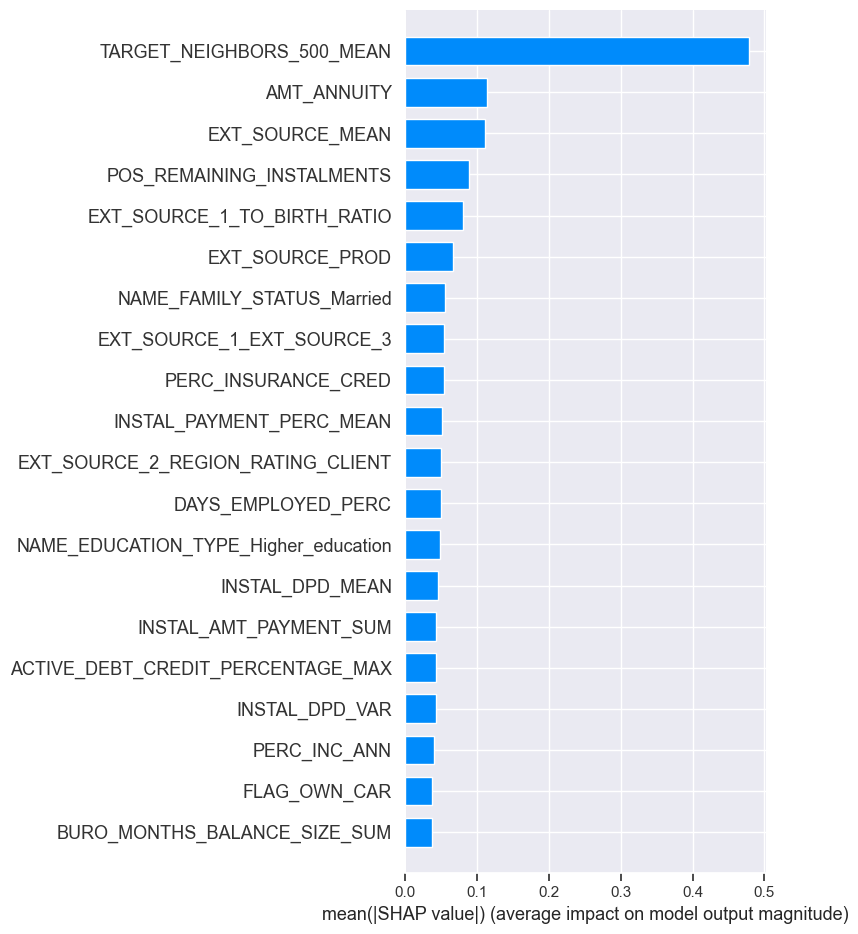

In [182]:
sns.set_style("darkgrid")
shap.summary_plot(shap_values, temp_total, plot_type="bar", max_display=20)

On retrouve à la 1re place la variable TARGET_NEIGHBORS_500_MEAN que nous avons créé lors du feature engineering avancé, à la 2e place le montant des annuités et à la 3e place la moyenne des scores clients calculés lors du
feature engineering basique.
De façon générale, on remarque la présence de nombreuses variables liées à ces scores clients, mais également des informations bancaires comme le nombre d’échéances restantes de crédits antérieurs.
Les informations personnelles du client comme son statut marital ou le fait qu’il ait fait des études supérieures sont également importantes pour le modèle.

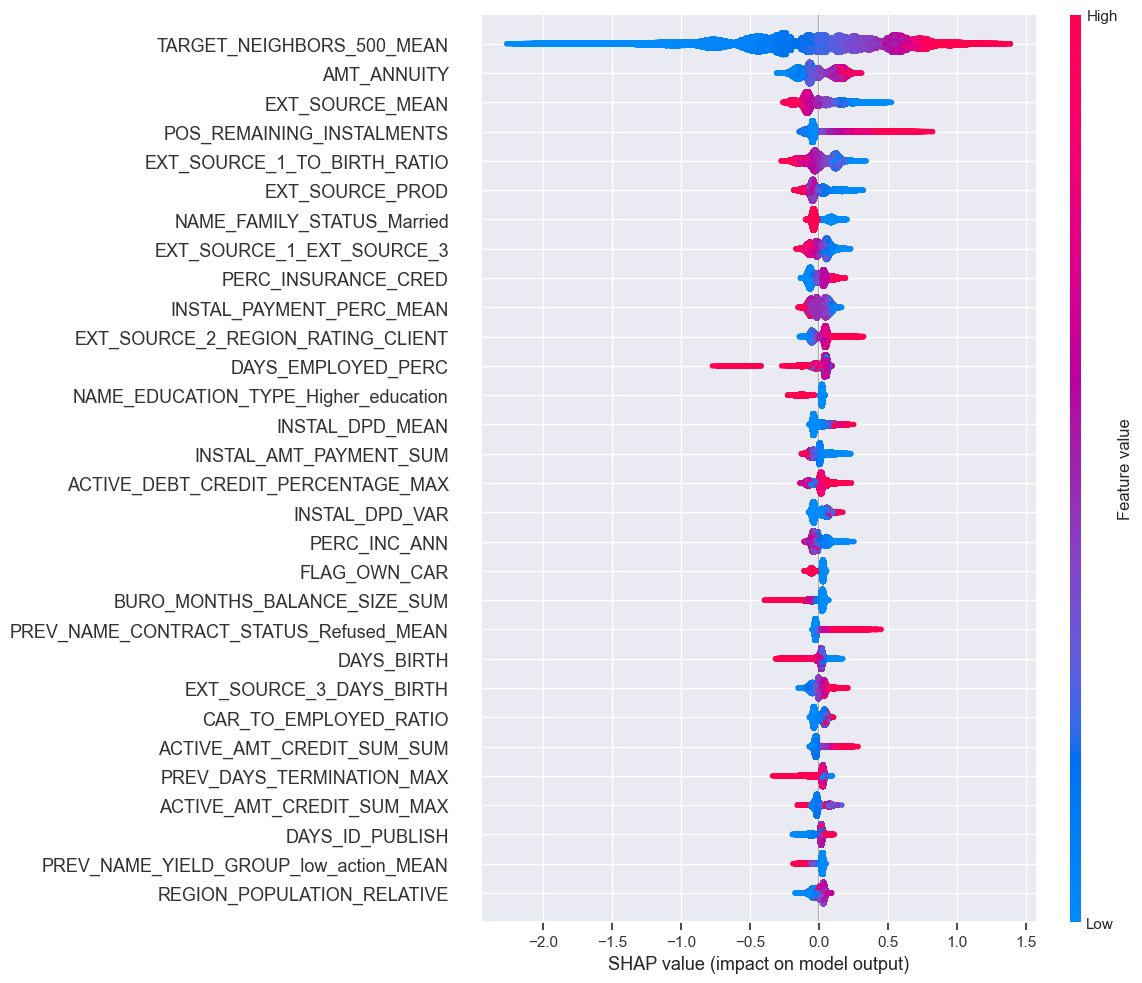

In [183]:
sns.set_style("darkgrid")
shap.summary_plot(shap_values, temp_total, max_display=30, plot_size=(12, 10))

On peut également expliquer la prédiction du modèle pour un client donné.

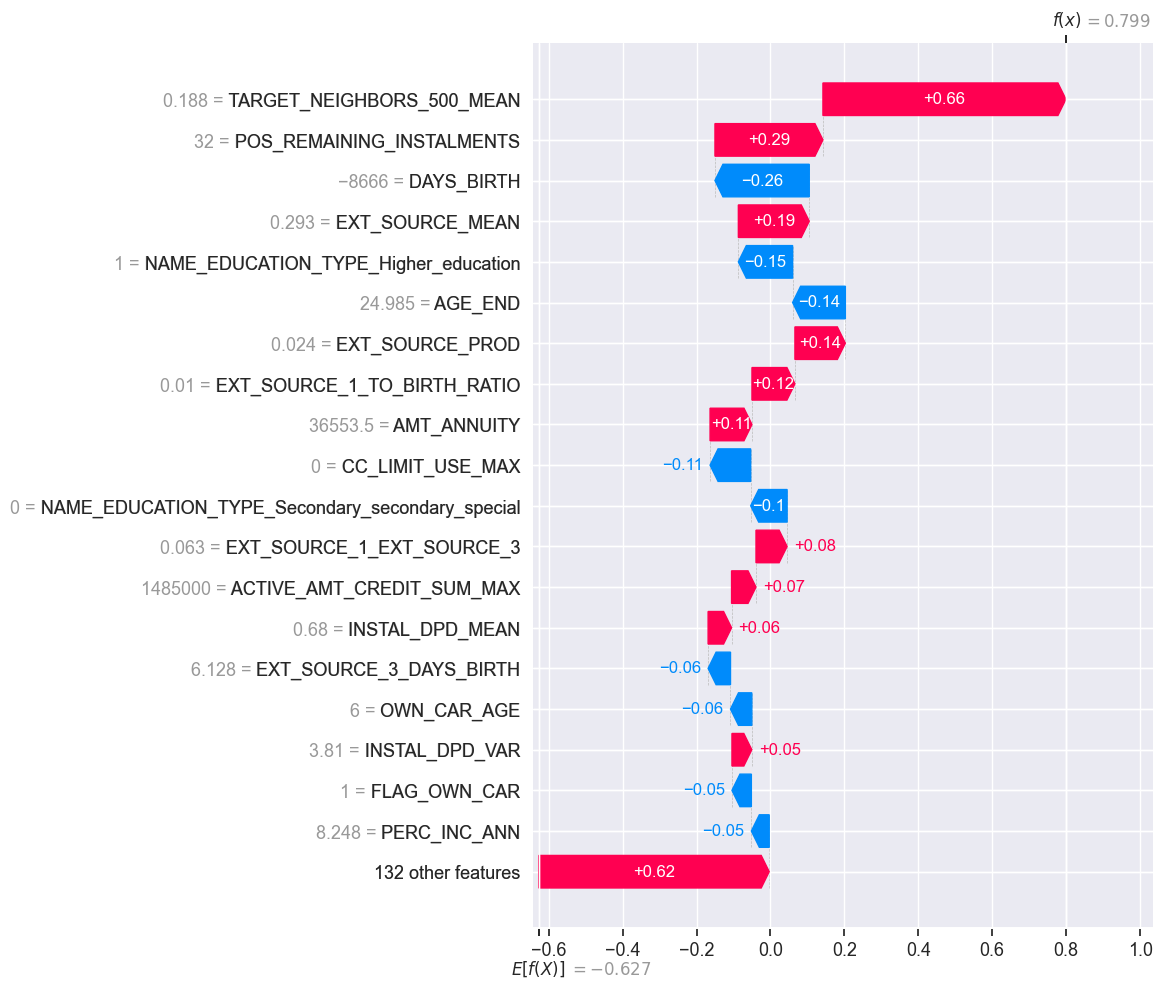

In [184]:
# Plot the SHAP waterfall plot for a specific instance
shap.waterfall_plot(shap_values[1220], max_display=20)

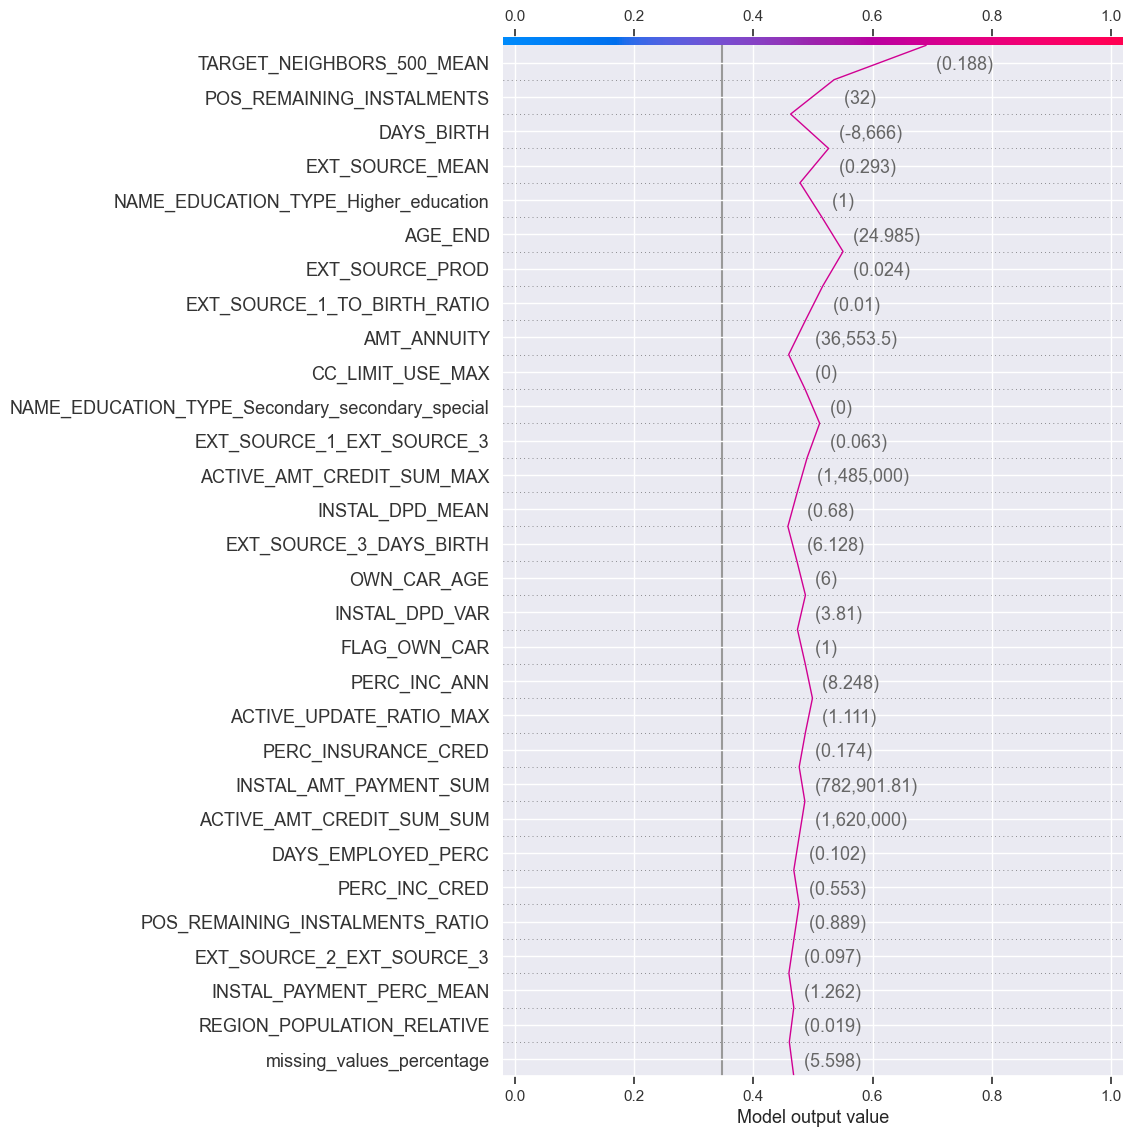

In [185]:
shap.decision_plot(explainer.expected_value, shap_values.values[1220, :], temp_total.iloc[1220, :], feature_display_range=slice(-1, -31, -1), link='logit')

<br>

---

##  <span style='background :#96e773' > 6. Data drift </span>

On analyse le drift avec la librairie Evidently en prenant comme données de référence le jeu d'entrainement et comme données en production le jeu de test.

In [ ]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset

In [ ]:
reference = temp_total.copy()
current = test_fs_mini.copy()
current = current.drop(columns='SK_ID_CURR')

In [ ]:
start_time = time.time()

report = Report(metrics=[DataDriftPreset()])
report.run(reference_data=reference, current_data=current)

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time

In [ ]:
report.save_html("Evidently_report_full.html")